In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm
from PIL import Image

In [2]:
## PYTORCH DATASET

# Dataset class
class DogBreedDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [3]:
# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

# Setup Data
train_folder = '/kaggle/input/dog-breed-dataset/dog-breed/train'
test_folder = '/kaggle/input/dog-breed-dataset/dog-breed/test'

train_dataset = DogBreedDataset(train_folder, transform=transform)
test_dataset = DogBreedDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print classes
target_to_class = {v: k for k, v in ImageFolder(train_folder).class_to_idx.items()}
print(target_to_class)

{0: 'Beagle', 1: 'Boxer', 2: 'Bulldog', 3: 'Dachshund', 4: 'German_Shepherd', 5: 'Golden_Retriever', 6: 'Labrador_Retriever', 7: 'Poodle', 8: 'Rottweiler', 9: 'Yorkshire_Terrier'}


In [4]:
## PYTORCH MODEL

# Model class
class SimpleDogClassifier(nn.Module):
    # Define parts of the model
    def __init__(self, num_classes=10):
        super(SimpleDogClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])  # Remove additional last layer
        
        enet_out_size = 1280 # Output size of EfficientNet-B0's feature extractor.
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(enet_out_size),
            nn.Dropout(0.5),
            nn.Linear(enet_out_size, num_classes)
        )
    
    # Connect these parts and return output
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        output = self.classifier(x)
        return output

# Initialize Model
model = SimpleDogClassifier(num_classes=10)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [5]:
## PYTORCH TRAINING LOOP

# Loss fn, optimer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epoch = 10
train_losses = []
train_accuracies = []

def calculate_accuracy(output, target):
    _, preds = torch.max(output, 1)
    correct = (preds == target).sum().item()
    return correct / target.size(0)

# Training function
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for images, labels in tqdm(train_loader, desc='Training Loop'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
        
    scheduler.step()
    
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = running_corrects / len(train_loader.dataset)
    
    return train_loss, train_accuracy

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Validation Loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()
    
    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = running_corrects / len(test_loader.dataset)
    
    return test_loss, test_accuracy

# Loop
for epoch in range(num_epoch):
    # Train the model
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Print epoch stats for training
    print(f"Epoch {epoch+1}/{num_epoch} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Training Loop:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.0477, Train Acc: 0.9844


Training Loop:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.0384, Train Acc: 0.9870


Training Loop:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.0502, Train Acc: 0.9922


Training Loop:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.0345, Train Acc: 0.9935


Training Loop:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.0311, Train Acc: 0.9948


Training Loop:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.0321, Train Acc: 0.9948


Training Loop:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.0245, Train Acc: 0.9987


Training Loop:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.0276, Train Acc: 0.9948


Training Loop:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.0263, Train Acc: 0.9974


Training Loop:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.0248, Train Acc: 0.9987


Validation Loop:   0%|          | 0/7 [00:00<?, ?it/s]

Test Loss: 0.0220, Test Accuracy: 0.9949


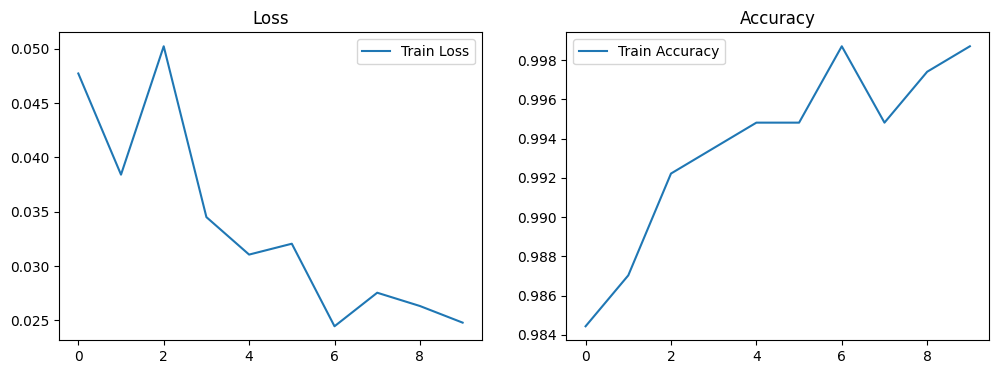

In [8]:
# Plotting the train loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# DogBreed Summary

## Dataset Handling
Ran a python script to split the dataset into Train and Test sets (80-20) then uploaded to Kaggle.

### DogBreedDataSet class
- __init__: Used **ImageFolder** class from `torchvision.dataset` to load images and labels from the uploaded dataset. It also automatically assigns a numeric label to each class based on the alphabetical order of the folder names.

- __len__: Total number of samples in the dataset, used by pytorch for batching.

- __getitem__: Retrieves a sample from the dataset at the specified index, used by  pytorch for applying transforms.

- **'classes' property**: Provides a convenient way to access class names.

### Transforms
Used **Compose** function from `torchvision.transform` to sequentially apply transformation to images. It takes a list of transformations as input and produces one output based on the list.

- Resizing each image to 128x128 px. Necessary for batching and feeding into the neural network.
- Randomly horizontal flip images to improve generalization.
- Rotating images by 10 degrees to enhance ability to detect rotated versions of objects.
- Adjusting brightness, contrast, saturation, hue by a factor of 0.2 (20%) to each image. This creates variation in images for better learning of the model. 
- Converts the image to a PyTorch tensor and scales the pixel values to the range 0-1. Necessary.

### Dataloader
Creating dataset using the DogBreedDataset class and applying the transform.  
DataLoader utility to iterate over the dataset.

## Model Creation

### SimpleDogClassifier class

- **SimpleDogClassifier(nn.Module):** Inherits from `nn.Module`, making it a custom neural network module.

- **Base Model:** Loading a pretrained **efficientnet_b0** from `timm` library.

- **Feature Extraction:** Extracts all layers from the base model, except the final classfication layer.

- **Classifier:** 
    - Batch normalization to the features helps in stabilizing and speeding up training.
    - Applies dropout with a probability of 0.5 to prevent overfitting by setting half of the activations to 0.
    - Fully connected layer that maps the features to the number of classes.
    
    
- Forward Pass: Passes the input x through the feature extractor, flattens the features into a 1D tensor for the classifier, passes the flattened features through the classifier to get the final output.

- **Initialize model** with number of classes.

## Training Loop

### Loss function
`nn.CrossEntropyLoss()` - Commonly used loss function for multi-class classification problems.

### Optimizer
`optim.Adam` - Designed specifically for training deep neural networks.

### Learning Rate Scheduler
`optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)` - Decays lr by 0.1 every 3 epochs.

### Device
Using CUDA-enabled GPU to train model.

### Accuracy Calculation Function
Calculates the accuracy as the ratio of correct predictions to the total number of samples.

### Train Function
- Set model to training mode.
- Iterate over the training dataset using `tqdm` for tracking progress.
- Move images and labels to the device -> Reset the gradients -> Computes the model's predictions -> Calculate loss -> Compute gradient -> Update model parameter -> Accumulate loss and no. of correct preds.
- Update LR scheduler
- Calculate avg training loss and accuracy.

### Evaluation Function
Same as train function but on test_loader and gradient computation disabled.

### Loop
Train model over number of epochs and print the stats.

### Visualize output
Using `matplotlib.pyplot`:  
- Plot the training accuracy and loss.  
- Plot confusion matrix for test set output.

---